In [18]:
#!pip install spotipy
#!pip install pandas
#!pip install openpyxl
#!pip install matplotlib
!pip install scikit-learn

     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
    --------------------------------------- 0.2/10.6 MB 3.9 MB/s eta 0:00:03
    --------------------------------------- 0.2/10.6 MB 4.6 MB/s eta 0:00:03
   - -------------------------------------- 0.5/10.6 MB 3.4 MB/s eta 0:00:03
   -- ------------------------------------- 0.7/10.6 MB 3.8 MB/s eta 0:00:03
   --- ------------------------------------ 1.0/10.6 MB 4.2 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/10.6 MB 4.2 MB/s eta 0:00:03
   ----- ---------------------------------- 1.5/10.6 MB 4.3 MB/s eta 0:00:03
   ----- ---------------------------------- 1.6/10.6 MB 4.2 MB/s eta 0:00:03
   ------ --------------------------------- 1.6/10.6 MB 3.9 MB/s eta 0:00:03
   ------ --

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pprint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE

In [3]:
cid = '25d521b807f44fc19a8b202da4c88248'
secret = 'd06c3e35075f4c7cb28347e6620067cf'
redirect_uri = 'http://localhost:8080/callback'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=cid, client_secret=secret, redirect_uri=redirect_uri))

In [4]:
def get_features(song, artist):
    # get track id information
    track_info = sp.search(q=f"track%2520{song}%2520&artist%2520{artist}", type='track')
    track_id = track_info["tracks"]["items"][0]["id"]
    # get audio_feature
    features = sp.audio_features(tracks=[track_id])
    track_name = track_info["tracks"]["items"][0]["name"]
    artist_id = track_info["tracks"]["items"][0]["artists"][0]["id"]
    artist_name = track_info["tracks"]["items"][0]["artists"][0]["name"]
    acousticness = features[0]["acousticness"]
    danceability = features[0]["danceability"]
    energy = features[0]["energy"]
    liveness = features[0]["liveness"]
    loudness = features[0]["loudness"]
    valence = features[0]["valence"]
    mode = features[0]["mode"]

    result = {  "artist" : artist_name,
                "artist_id" : artist_id,
                "track_name" : track_name,
                "track_id" : track_id,
                "acousticness" : acousticness,
                "danceability" : danceability,
                "energy" : energy,
                "liveness" : liveness,
                "loudness" : loudness,
                "valence" : valence,
                "mode" : mode}

    return result


In [5]:
get_features("파라다이스 (Feat. 박우진 of AB6IX)", "김재환")

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=4YXWk4YOEmlu8bWlzNObD7:
 Max Retries, reason: too many 429 error responses

In [14]:

# 엑셀 파일 불러오기
excel_file = r"Data\theme_playlist.xlsx"  # 엑셀 파일 경로
df = pd.read_excel(excel_file, sheet_name="sleep")
# 새로운 데이터프레임 생성
new_df = pd.DataFrame(columns=["artist", "artist_id", "track_name", "track_id", "acousticness", "danceability", "energy", "liveness", "loudness", "valence", "mode"])
# 각 곡에 대해 함수를 적용하여 특성 가져오기
for index, row in df.iterrows():
    song = row["Song"]  # 엑셀 파일에서 곡 제목이 들어있는 열의 이름
    artist = row["Artist"]  # 엑셀 파일에서 아티스트 이름이 들어있는 열의 이름
    features = get_features(song, artist)
    new_df = pd.concat([new_df, pd.DataFrame(features, index=[0])], ignore_index=True)
# new_df.head()
# 새로운 데이터프레임을 엑셀 파일로 저장
new_excel_file = r"Data\sleep_feature.xlsx"  # 새로운 엑셀 파일 경로
new_df.to_excel(new_excel_file, index=False)

C:\Users\Shin\AppData\Local\Temp\ipykernel_4584\2356422209.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame(features, index=[0])], ignore_index=True)


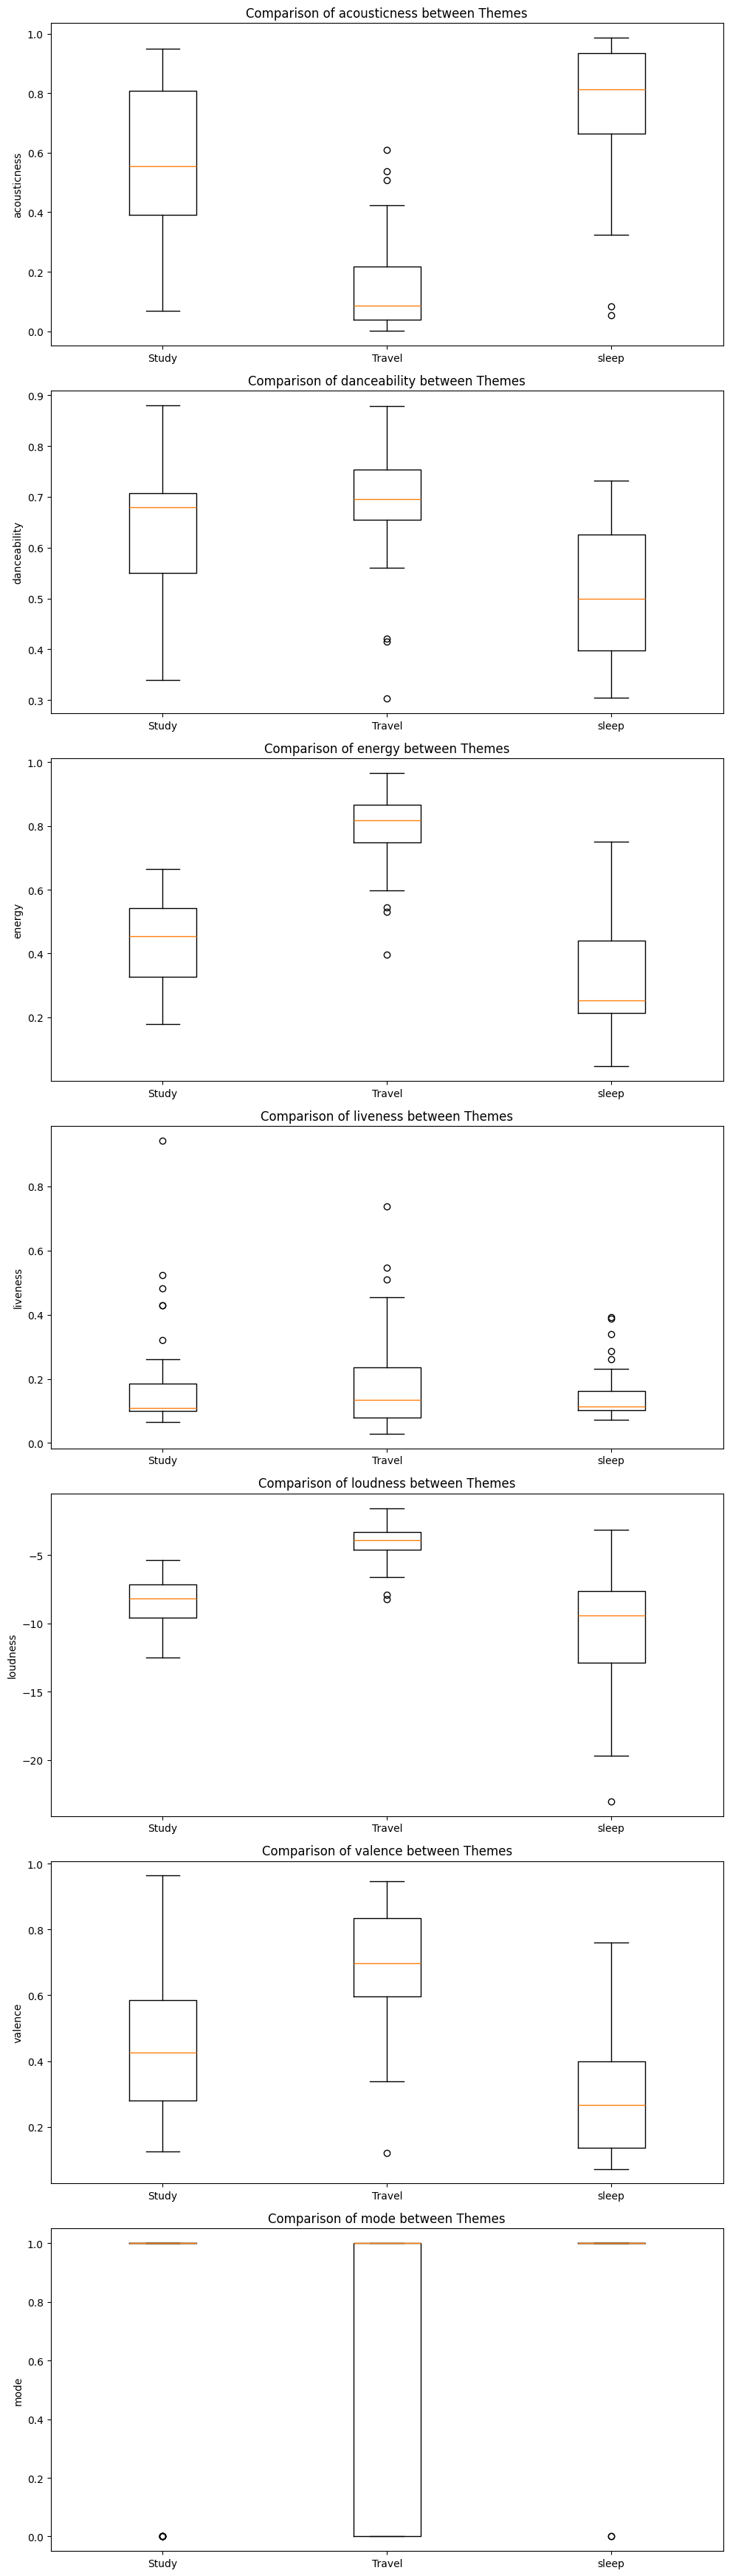

In [16]:
study_excel = r"Data\study_feature.xlsx"
trip_excel = r"Data\trip_feature.xlsx"
sleep_excel = r"Data\sleep_feature.xlsx"

study_df = pd.read_excel(study_excel)
trip_df = pd.read_excel(trip_excel)
sleep_df = pd.read_excel(sleep_excel)


df_numeric_study = study_df.drop(columns=['artist', 'artist_id', 'track_name', 'track_id'])
df_numeric_trip = trip_df.drop(columns=['artist', 'artist_id', 'track_name', 'track_id'])
df_numeric_sleep = sleep_df.drop(columns=['artist', 'artist_id', 'track_name', 'track_id'])
# 상자 그림 그리기

# 'acousticness'에 대한 상자 그림 비교
fig, axes = plt.subplots(nrows=len(df_numeric_study.columns), ncols=1, figsize=(10, len(df_numeric_study.columns) * 5))

for i, column in enumerate(df_numeric_study.columns):
    axes[i].boxplot([df_numeric_study[column], df_numeric_trip[column], df_numeric_sleep[column]], labels=['Study', 'Travel', 'sleep'])
    axes[i].set_title(f'Comparison of {column} between Themes')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()


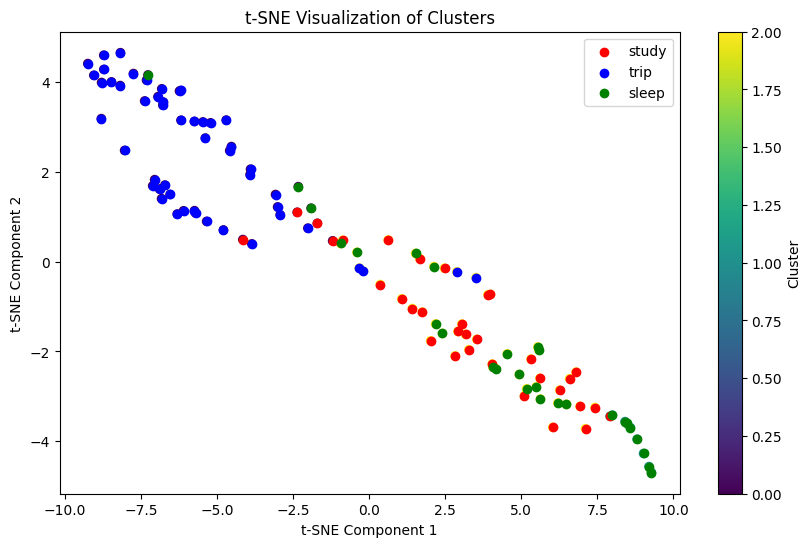

In [31]:
df_numeric_study['theme'] = 'study'
df_numeric_trip['theme'] = 'trip'
df_numeric_sleep['theme'] = 'sleep'

df_cluster = pd.concat([df_numeric_study, df_numeric_trip, df_numeric_sleep], axis=0)

# K-means 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_cluster.drop(columns=['theme']))

# t-SNE를 사용하여 데이터 시각화
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_cluster.drop(columns=['theme']))

# 시각화

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
for theme, color in zip(['study', 'trip', 'sleep'], ['red', 'blue', 'green']):
    plt.scatter(tsne_results[df_cluster['theme'] == theme, 0], tsne_results[df_cluster['theme'] == theme, 1], c=color, label=theme)
plt.legend()
plt.show()


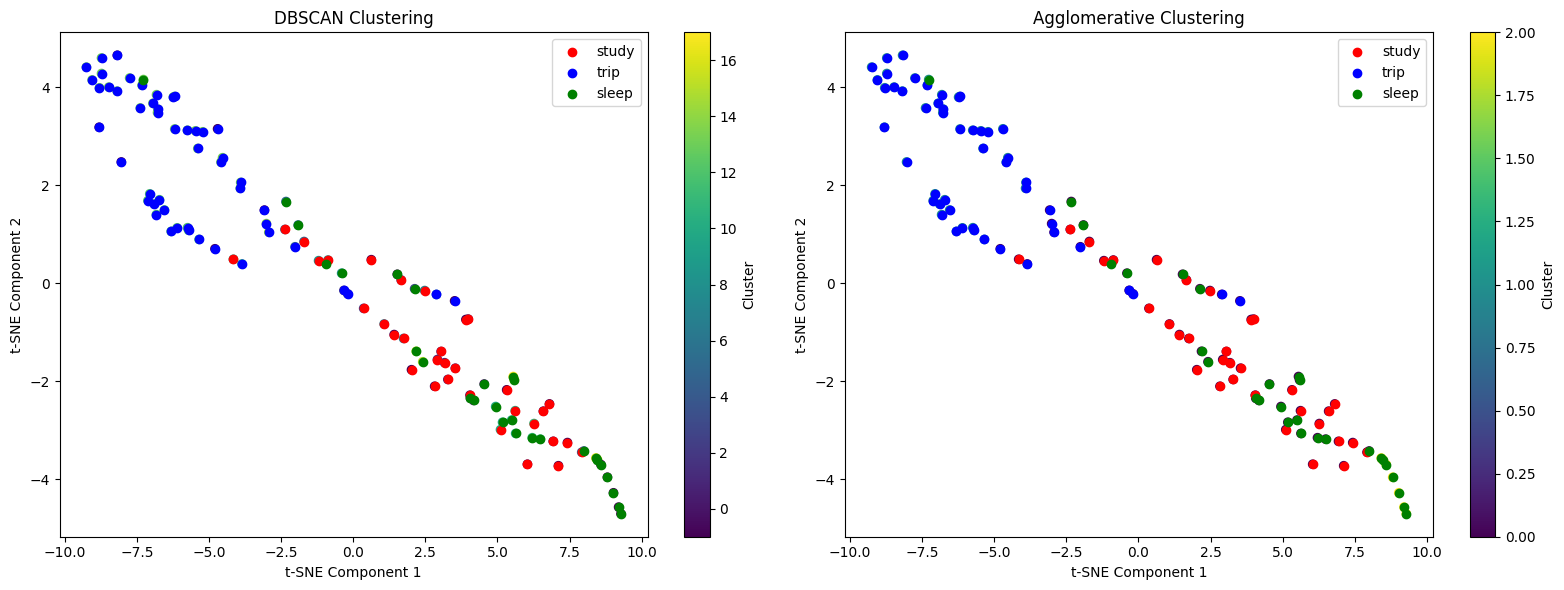

In [32]:
# DBSCAN 클러스터링
dbscan = DBSCAN(eps=0.5, min_samples=2)
clusters_dbscan = dbscan.fit_predict(df_cluster.drop(columns=['theme']))

# Agglomerative Clustering 클러스터링
agglomerative = AgglomerativeClustering(n_clusters=3)
clusters_agglo = agglomerative.fit_predict(df_cluster.drop(columns=['theme']))

# t-SNE를 사용하여 데이터 시각화
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_cluster.drop(columns=['theme']))

# 시각화
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters_dbscan, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
for theme, color in zip(['study', 'trip', 'sleep'], ['red', 'blue', 'green']):
    plt.scatter(tsne_results[df_cluster['theme'] == theme, 0], tsne_results[df_cluster['theme'] == theme, 1], c=color, label=theme)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters_agglo, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
for theme, color in zip(['study', 'trip', 'sleep'], ['red', 'blue', 'green']):
    plt.scatter(tsne_results[df_cluster['theme'] == theme, 0], tsne_results[df_cluster['theme'] == theme, 1], c=color, label=theme)
plt.legend()

plt.tight_layout()
plt.show()

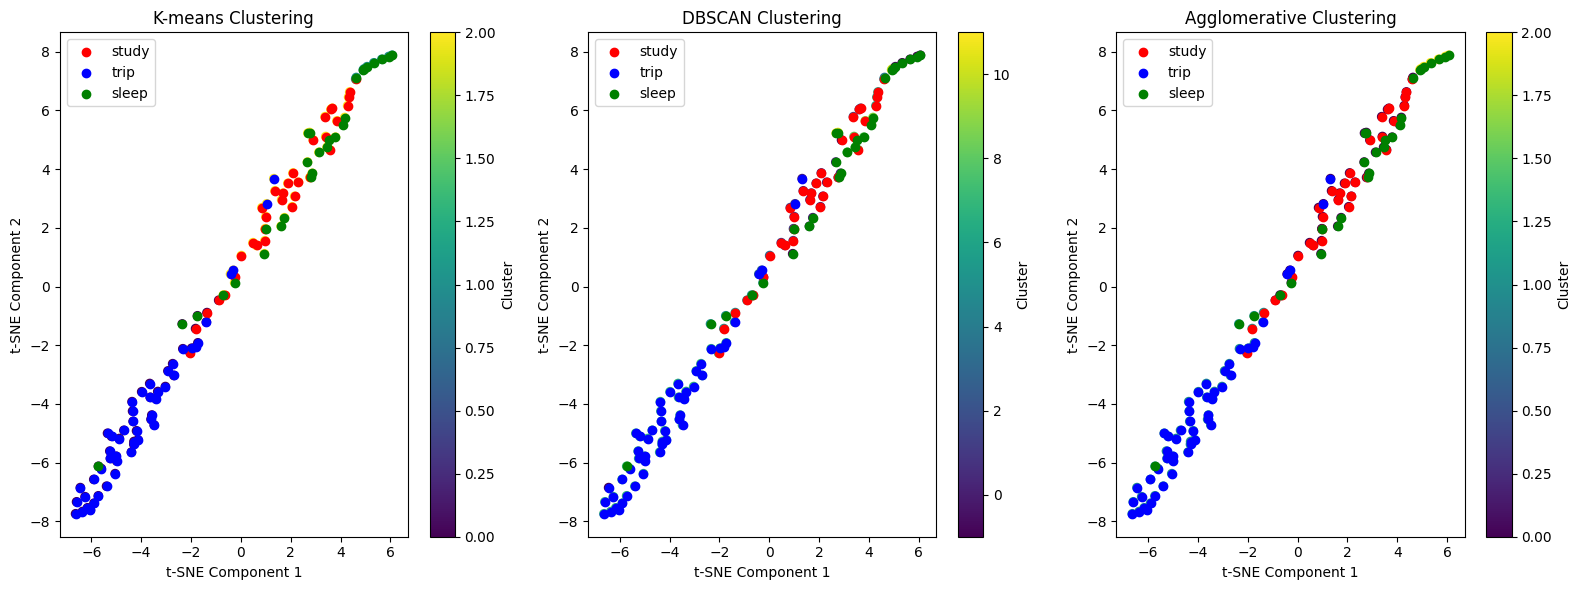

In [42]:
df_numeric_study['theme'] = 'study'
df_numeric_trip['theme'] = 'trip'
df_numeric_sleep['theme'] = 'sleep'

df_cluster = pd.concat([df_numeric_study, df_numeric_trip, df_numeric_sleep], axis=0)

# K-means 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = kmeans.fit_predict(df_cluster.drop(columns=['theme', 'liveness', 'mode']))

# DBSCAN 클러스터링
dbscan = DBSCAN(eps=0.5, min_samples=2)
clusters_dbscan = dbscan.fit_predict(df_cluster.drop(columns=['theme', 'liveness', 'mode']))

# Agglomerative Clustering 클러스터링
agglomerative = AgglomerativeClustering(n_clusters=3)
clusters_agglo = agglomerative.fit_predict(df_cluster.drop(columns=['theme', 'liveness', 'mode']))

# t-SNE를 사용하여 데이터 시각화
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_cluster.drop(columns=['theme', 'liveness', 'mode']))

# 시각화
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters_kmeans, cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
for theme, color in zip(['study', 'trip', 'sleep'], ['red', 'blue', 'green']):
    plt.scatter(tsne_results[df_cluster['theme'] == theme, 0], tsne_results[df_cluster['theme'] == theme, 1], c=color, label=theme)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters_dbscan, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
for theme, color in zip(['study', 'trip', 'sleep'], ['red', 'blue', 'green']):
    plt.scatter(tsne_results[df_cluster['theme'] == theme, 0], tsne_results[df_cluster['theme'] == theme, 1], c=color, label=theme)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters_agglo, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
for theme, color in zip(['study', 'trip', 'sleep'], ['red', 'blue', 'green']):
    plt.scatter(tsne_results[df_cluster['theme'] == theme, 0], tsne_results[df_cluster['theme'] == theme, 1], c=color, label=theme)
plt.legend()

plt.tight_layout()
plt.show()